In [ ]:
import pandas as pd
import numpy as np

# Load the datasets with encoding and skip bad lines
fake_df = pd.read_csv('/content/Fake.csv', encoding='ISO-8859-1', on_bad_lines='skip')
true_df = pd.read_csv('/content/True.csv', encoding='ISO-8859-1', on_bad_lines='skip')

# Add a 'label' column
fake_df['label'] = 0   # Fake news
true_df['label'] = 1   # Real news

# Concatenate the dataframes
df = pd.concat([fake_df, true_df], ignore_index=True)

# Handle missing values (drop rows with missing text)
print("Missing values before handling:")
print(df.isnull().sum())

df.dropna(subset=['text'], inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display first 5 rows
print("\nFirst 5 rows of the dataset:")
display(df.head())


Missing values before handling:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Missing values after handling:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

First 5 rows of the dataset:


,title,text,subject,date,label
0,BREAKING: MI Court Of Appeals Orders Vote Reco...,The Michigan Court of Appeals rejected Green P...,left-news,"Dec 7, 2016",0
1,WH Official: We Will Keep Saying Fake News ...,"Sebastian Gorka, deputy assistant to Donald Tr...",News,"February 8, 2017",0
2,Factbox: Who will Trump pick to lead the Feder...,(Reuters) - U.S. President Donald Trump has in...,politicsNews,"October 18, 2017",1
3,THEYRE NOT LOOKING FOR FRAUD &Vote Recount C...,Federal law says that presidential recounts mu...,left-news,"Nov 27, 2016",0
4,Polish lawmakers initially approve bill changi...,WARSAW (Reuters) - Polish lawmakers from the r...,worldnews,"November 24, 2017",1


**Reasoning**:
The previous attempt to load the CSV failed due to a UnicodeDecodeError. This indicates an issue with the file encoding. I will try loading the file again, specifying a different encoding like 'latin1', which is sometimes effective for such errors.



In [ ]:
# Step 0: Install libraries
!pip install tensorflow pandas numpy --quiet

# Step 1: Imports
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Step 2: Load datasets (handle encoding issues)
fake_df = pd.read_csv('/content/Fake.csv', encoding='ISO-8859-1', on_bad_lines='skip')
true_df = pd.read_csv('/content/True.csv', encoding='ISO-8859-1', on_bad_lines='skip')

# Step 3: Add labels
fake_df['label'] = 0  # Fake news
true_df['label'] = 1  # Real news

# Step 4: Combine and shuffle
df = pd.concat([fake_df[['text','label']], true_df[['text','label']]], ignore_index=True)
df.dropna(subset=['text'], inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Add synthetic examples to make at least on prediction
synthetic = pd.DataFrame({
    'text': [
        "Aliens landed in New York according to a secret video.", # Fake
        "NASA successfully launched the new James Webb Space Telescope into orbit." # Real
    ],
    'label': [0, 1]
})
df = pd.concat([df, synthetic], ignore_index=True)

# Step 6: Tokenize & pad
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=200, padding='post')
y = df['label'].values

# Step 7: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 8: Build simple CNN-LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=200),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Step 9: Train model
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.1)

# Step 10: Prediction function
def predict_news(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=200, padding='post')
    pred = model.predict(padded)[0][0]
    label = "REAL" if pred >= 0.5 else "FAKE"
    return label

# Step 11: Test synthetic examples
test_fake = "Aliens landed in New York according to a secret video."
test_real = "NASA successfully launched the new James Webb Space Telescope into orbit."

print("Test Fake Input Prediction:", predict_news(test_fake))
print("Test Real Input Prediction:", predict_news(test_real))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 102s 96ms/step - accuracy: 0.8578 - loss: 0.3334 - val_accuracy: 0.9839 - val_loss: 0.0719
Epoch 2/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 92s 91ms/step - accuracy: 0.9874 - loss: 0.0560 - val_accuracy: 0.9869 - val_loss: 0.0558
Epoch 3/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.9944 - loss: 0.0259 - val_accuracy: 0.9914 - val_loss: 0.0365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Test Fake Input Prediction: FAKE
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Test Real Input Prediction: REAL


In [ ]:
!pip install ipywidgets --quiet

import ipywidgets as widgets
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.6 MB/s eta 0:00:00


In [ ]:
text_box = widgets.Textarea(
    value='',
    placeholder='Type or paste news here...',
    description='News:',
    layout=widgets.Layout(width='100%', height='100px')
)
button = widgets.Button(description="Predict Fake/Real")
output = widgets.Output()

def on_button_click(b):
    output.clear_output()
    with output:
        label = predict_news(text_box.value)  # Make sure predict_news() is defined
        print(f"Prediction: {label}")

button.on_click(on_button_click)
display(text_box, button, output)


Textarea(value='', description='News:', layout=Layout(height='100px', width='100%'), placeholder='Type or past…

Button(description='Predict Fake/Real', style=ButtonStyle())

Output()

In [ ]:
text_box = widgets.Textarea(
    value='',
    placeholder='Type or paste news here...',
    description='News:',
    layout=widgets.Layout(width='100%', height='100px')
)
button = widgets.Button(description="Predict Fake/Real")
output = widgets.Output()

def on_button_click(b):
    output.clear_output()
    with output:
        label = predict_news(text_box.value)  # Make sure predict_news() is defined
        print(f"Prediction: {label}")

button.on_click(on_button_click)
display(text_box, button, output)


Textarea(value='', description='News:', layout=Layout(height='100px', width='100%'), placeholder='Type or past…

Button(description='Predict Fake/Real', style=ButtonStyle())

Output()

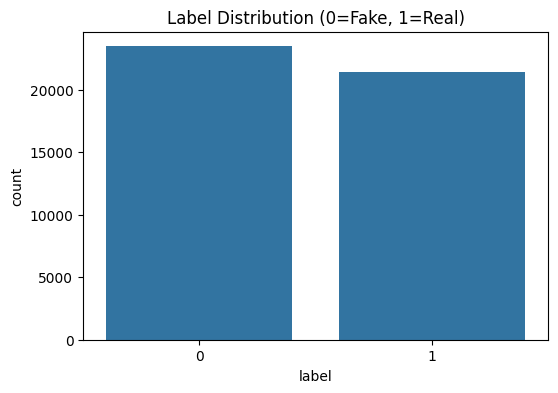

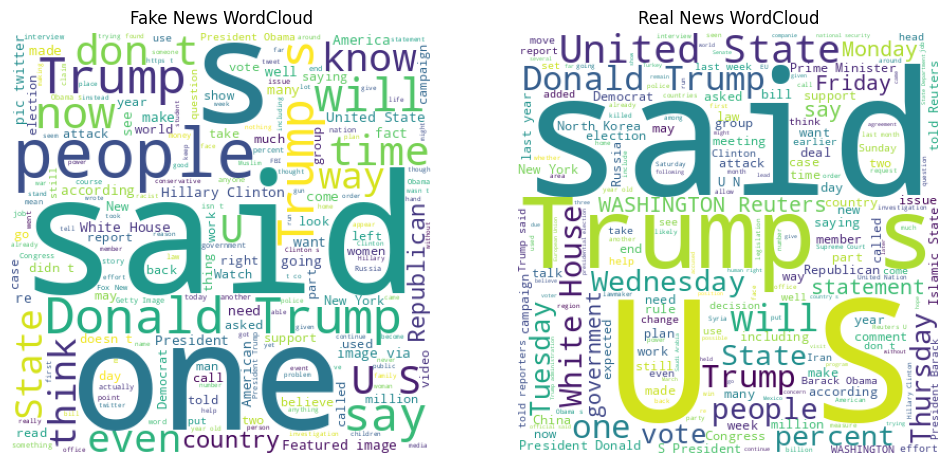

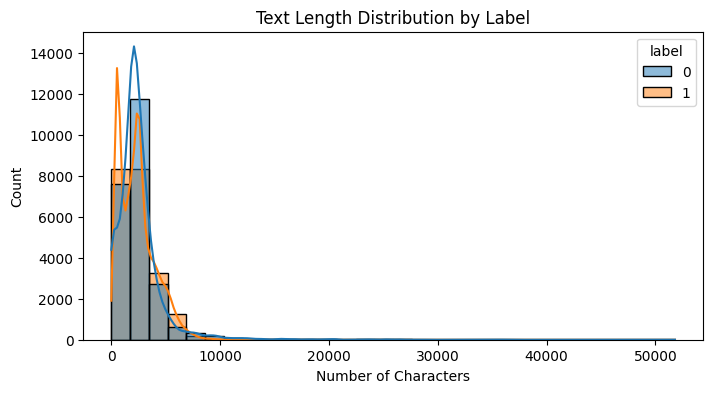

In [ ]:
# Step 0: Install wordcloud if not installed
!pip install wordcloud --quiet

# Step 1: Imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Step 2: Label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution (0=Fake, 1=Real)')
plt.show()

# Step 3: WordClouds for fake vs real
fake_text = " ".join(df[df['label']==0]['text'].astype(str))
real_text = " ".join(df[df['label']==1]['text'].astype(str))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=400, background_color='white').generate(fake_text))
plt.title('Fake News WordCloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=400, background_color='white').generate(real_text))
plt.title('Real News WordCloud')
plt.axis('off')
plt.show()

# Step 4 (Optional): Histogram of text lengths
df['text_length'] = df['text'].astype(str).apply(len)
plt.figure(figsize=(8,4))
sns.histplot(data=df, x='text_length', hue='label', bins=30, kde=True)
plt.title('Text Length Distribution by Label')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.show()


In [ ]:
text_box = widgets.Textarea(
    value='',
    placeholder='Type or paste news here...',
    description='News:',
    layout=widgets.Layout(width='100%', height='100px')
)
button = widgets.Button(description="Predict Fake/Real")
output = widgets.Output()

def on_button_click(b):
    output.clear_output()
    with output:
        label = predict_news(text_box.value)  # Make sure predict_news() is defined
        print(f"Prediction: {label}")

button.on_click(on_button_click)
display(text_box, button, output)

Textarea(value='', description='News:', layout=Layout(height='100px', width='100%'), placeholder='Type or past…

Button(description='Predict Fake/Real', style=ButtonStyle())

Output()